In [1]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.set_cmap("magma")

<Figure size 800x550 with 0 Axes>

## Test of the Shallow Water model

In [2]:
#from DA_PoC.dynamical_systems.sw_numerical_model 
from DA_PoC.dynamical_systems.examples.sw import SWModelJax
from DA_PoC.common.numerical_model import NumericalModel

from DA_PoC.common.observation_operator import LinearObservationOperator
import numpy as np

In [3]:
n_pts = 32
n_x = n_pts
dx = 5e3
n_y = n_pts
dy = 5e3
swmodel = SWModelJax(n_x, dx, n_y, dy, periodic_x=True)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
state_dimension = 3 * swmodel.state_variable_length
obs_dimension = swmodel.state_variable_length
h_no_nan = np.eye(swmodel.state_variable_length)
for i in range(swmodel.state_variable_length):
    if i % n_pts == 0:
        h_no_nan[i, i] = 0
        h_no_nan[i-1, i-1] = 0

H_obs = np.hstack(
    [
        np.zeros((swmodel.state_variable_length, swmodel.state_variable_length)),
        np.zeros((swmodel.state_variable_length, swmodel.state_variable_length)),
        h_no_nan,
    ]
)
obs_operator = LinearObservationOperator(Hmatrix=H_obs)
window = 50
# print(f"{lorenz.obs.shape=}")
# print(f"{lorenz.H=}")
numerical_model_sw = NumericalModel(state_dimension, obs_dimension)
background = np.zeros(state_dimension)
background[swmodel.slice_h] = swmodel.depth
numerical_model_sw.background = background
numerical_model_sw.background_error_cov_inv = 1.0 * np.eye(state_dimension)
numerical_model_sw.set_observation_operator(obs_operator)
def remove_nan(array):
    return np.where(np.isnan(array), 0, array)

# def forw(x):
#     x1 = remove_nan(swmodel.forward(x, n_steps=window, pbar=False))
#     return np.concatenate([x[:, None], x1[:, None]], axis=-1)
numerical_model_sw.set_forward(lambda x: remove_nan(swmodel.forward(x, n_steps=window, pbar=False)))
# numerical_model_sw.set_forward(forw)

numerical_model_sw.set_tangent_linear(
    lambda x: np.asarray(swmodel.forward_TLM(x, n_steps=window)[0])
)
x0_t = background
x0_t[swmodel.slice_h] += 3 * np.random.randn(swmodel.state_variable_length)

Observation operator set already


In [5]:
# new_state = numerical_model_sw.forward_no_obs(x0_t)
def generate_obs_no_noise(x0, n_steps):
    return remove_nan(swmodel.forward(x0, n_steps=n_steps)[swmodel.slice_h])

true_obs = generate_obs_no_noise(x0_t, window)


51it [00:06,  7.45it/s]                        


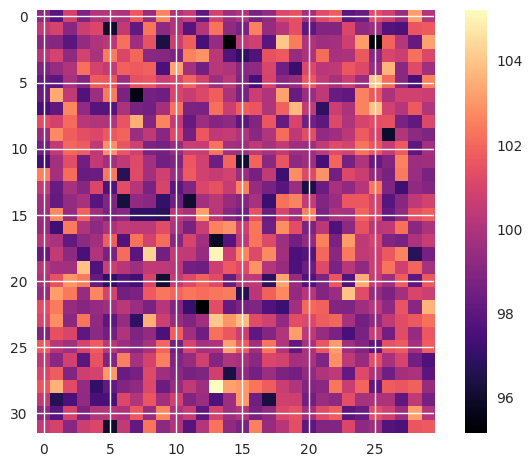

In [6]:
plt.imshow(true_obs.reshape(n_pts, n_pts)[:, 1:-1])
plt.colorbar()

In [7]:
x1 = x0_t + np.random.normal(size=x0_t.shape)

In [8]:
noisy_obs = true_obs +  np.random.normal(loc=0, scale=0.1, size=true_obs.shape)

In [9]:
numerical_model_sw.set_obs(noisy_obs)
print(numerical_model_sw.cost_function(x0_t + np.random.normal(size=x0_t.shape)))
print(numerical_model_sw.cost_function(x0_t))

2922.021478951537
4.960081085682543


51it [00:31,  1.62it/s]                        


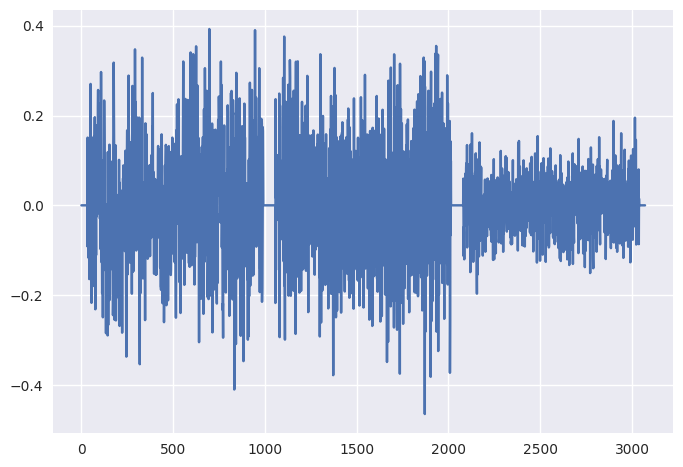

In [10]:
cost = numerical_model_sw.cost_function(x0_t)
grad = numerical_model_sw.gradient(x0_t)
plt.plot(grad)

In [11]:
gn = numerical_model_sw.gauss_newton_hessian_matrix(x1)

51it [00:28,  1.77it/s]                        


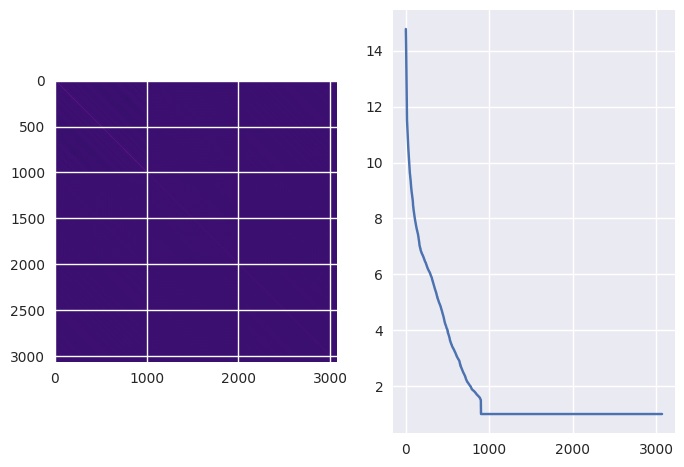

In [12]:
plt.subplot(1, 2, 1)
plt.imshow(gn)
plt.subplot(1, 2, 2)
plt.plot(np.linalg.svd(gn, compute_uv=False))

In [13]:
np.linalg.cond(gn)

14.777028453512122

In [14]:
import os
os.getcwd()
from datetime import date, datetime

[-1.28150824e+00  1.13515402e-02  2.11426901e+00 ...  9.78119715e+01
  9.22142396e+01  1.03013703e+02]


3344.4334929342695

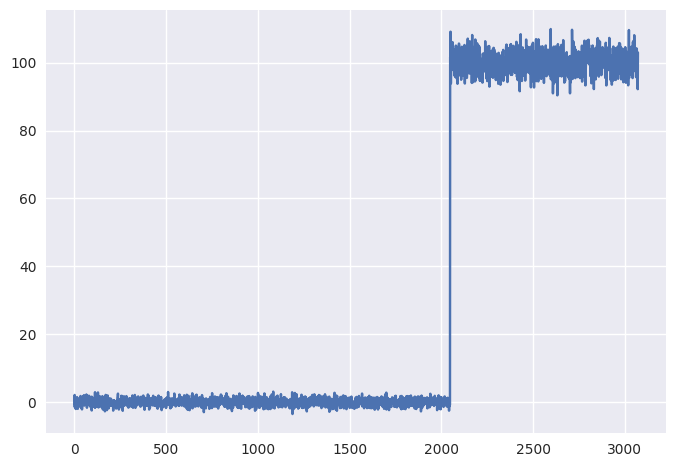

In [15]:
plt.plot(x1)
print(x1)
numerical_model_sw.cost_function(x1)

In [16]:
# exp_name = datetime.now().strftime("%H:%M:%S")
# gn_result = numerical_model_sw.GNmethod(
#     x1,
#     verbose=True,
#     prec=None,
#     log_file=os.path.join(os.getcwd(), "log_sw.txt"),
#     exp_name=exp_name,
#     i_cycle=0,
# )
# gn_x = gn_result['gn_x']

In [17]:
exp_name = datetime.now().strftime("%H:%M:%S")
numerical_model_sw.r = 500
gn_result = numerical_model_sw.GNmethod(
    x0_t + 2 * np.random.normal(size=x0_t.shape),
    verbose=True,
    log_file=os.path.join(os.getcwd(), "log_sw.txt"),
    exp_name=exp_name,
    i_cycle=0,
    prec = 'spectralLMP'
)
gn_x = gn_result['gn_x']



    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec


51it [00:30,  1.68it/s]                        
51it [00:30,  1.68it/s]                        
51it [00:30,  1.68it/s]                        
51it [00:30,  1.67it/s]                        


16:11:46,     0,     0, 12686.1882,       10, 1304.35, 1.564e+01, 4.040e+00


51it [00:30,  1.69it/s]                        
51it [00:29,  1.72it/s]                        
51it [00:33,  1.52it/s]                        
51it [00:32,  1.57it/s]                        


16:11:46,     0,     1, 129.3581,       10, 1281.56, 1.445e+01, 3.953e+00


51it [00:32,  1.56it/s]                        
51it [00:31,  1.60it/s]                        
51it [00:31,  1.63it/s]                        
51it [00:31,  1.64it/s]                        


16:11:46,     0,     2,   1.8315,       10, 1281.30, 1.441e+01, 3.955e+00


In [18]:
GtG = numerical_model_sw.gauss_newton_hessian_matrix(x0_t + 2 * np.random.normal(size=x0_t.shape))

51it [00:32,  1.59it/s]                        


In [19]:
w, v = np.linalg.eig(GtG)
wh, vh = np.linalg.eigh(GtG)

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


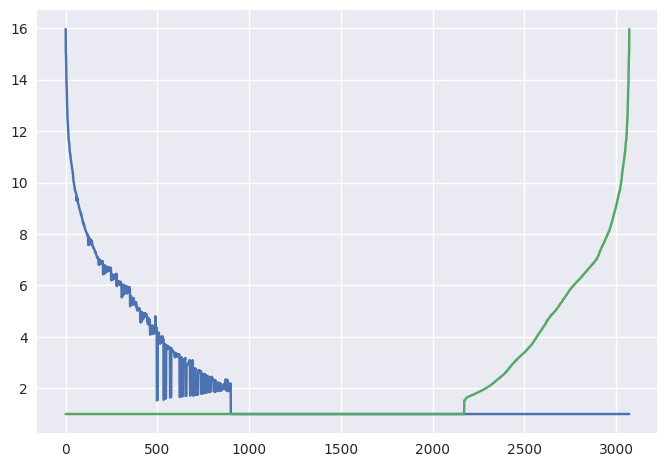

In [20]:
plt.plot(w)
plt.plot(wh)

[-1.28150824  0.01135154  2.11426901 ...  0.11652297 -0.66559928
 -0.33423344]


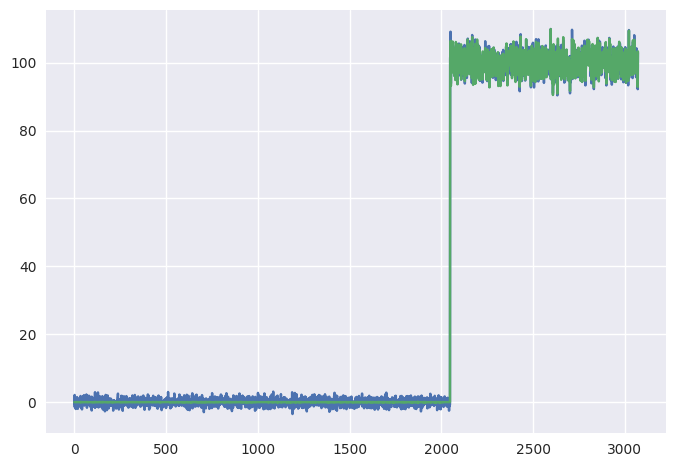

In [21]:
plt.plot(x1)
plt.plot(gn_x)
print(x1 - gn_x)

## Data Assimilation

In [22]:
from DA_PoC.variational.incrementalCG import Incremental4DVarCG

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# print(background.shape)
x_t = numerical_model_sw.forward_no_obs(background + np.random.normal(size=background.shape))
truth = numerical_model_sw.obs_operator(x_t)
print(x_t.shape, truth.shape)


(3072,) (1024,)


In [24]:
numerical_model_sw.n

3072

In [25]:
np.concatenate([truth[:, None], truth[:, None]], axis=-1).shape

(1024, 2)

In [26]:
def get_next_obs(x0, sigma_obs=1.0):
    x_t = numerical_model_sw.forward_no_obs(x0)
    truth = numerical_model_sw.obs_operator(x_t)
    truth = np.concatenate([truth[:, None], truth[:, None]], axis=-1)
    obs = truth + sigma_obs * np.random.normal(size = truth.shape)
    obs = np.concatenate([obs[:, None], obs[:, None]], axis=-1)
    return x_t, x_t, truth
numerical_model_sw.nobs = 1

In [27]:
DA_exp = Incremental4DVarCG(
    state_dimension=numerical_model_sw.n,
    bounds=None,
    numerical_model=numerical_model_sw,
    observation_operator=obs_operator,
    x0_run=x0_t,
    x0_analysis=None,
    get_next_observations=get_next_obs,
    n_cycle=5,
    n_outer=3,
    n_inner=100,
    prec=None,
    plot=False,
    log_append=False,
    save_all=False
)


In [28]:
DA_exp.run()

    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec


51it [00:31,  1.64it/s]                        
51it [00:31,  1.63it/s]                        
51it [00:31,  1.63it/s]                        
51it [00:31,  1.61it/s]                        


 default,     0,     0, 3142.4503,       37, 1286.71, 1.482e+01, 1.482e+01


51it [00:31,  1.63it/s]                        
51it [00:30,  1.66it/s]                        
51it [00:32,  1.55it/s]                        
51it [00:32,  1.57it/s]                        


 default,     0,     1,   9.4393,       33, 1281.31, 1.442e+01, 1.442e+01


51it [00:31,  1.60it/s]                        
51it [00:32,  1.58it/s]                        
51it [00:31,  1.62it/s]                        
51it [00:34,  1.50it/s]                        


 default,     0,     2,   0.0001,       24, 1281.30, 1.442e+01, 1.442e+01
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec


51it [00:29,  1.75it/s]                        
51it [00:31,  1.62it/s]                        
51it [00:33,  1.54it/s]                        
51it [00:32,  1.55it/s]                        


 default,     1,     0, 330135.0009,       36, 1279.50, 1.445e+01, 1.445e+01


51it [00:32,  1.59it/s]                        
51it [00:29,  1.72it/s]                        
51it [00:32,  1.55it/s]                        
51it [00:32,  1.59it/s]                        


 default,     1,     1, 726.2615,       33, 1282.30, 1.448e+01, 1.448e+01


51it [00:31,  1.64it/s]                        
51it [00:30,  1.66it/s]                        
51it [00:31,  1.62it/s]                        
51it [00:33,  1.52it/s]                        


 default,     1,     2, 712.6020,       29, 1282.27, 1.449e+01, 1.449e+01
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec


51it [00:32,  1.58it/s]                        
51it [00:31,  1.64it/s]                        
51it [00:31,  1.62it/s]                        
51it [00:32,  1.55it/s]                        


 default,     2,     0, 331541.8643,       37, 1280.29, 1.459e+01, 1.459e+01


51it [00:31,  1.64it/s]                        
51it [00:30,  1.70it/s]                        
51it [00:32,  1.59it/s]                        
51it [00:31,  1.62it/s]                        


 default,     2,     1, 436.9656,       33, 1282.60, 1.465e+01, 1.465e+01


51it [00:28,  1.78it/s]                        
51it [00:30,  1.67it/s]                        
51it [00:31,  1.61it/s]                        
51it [00:31,  1.63it/s]                        


 default,     2,     2, 415.0612,       28, 1282.58, 1.465e+01, 1.465e+01
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec


51it [00:30,  1.67it/s]                        
51it [00:31,  1.63it/s]                        
51it [00:32,  1.58it/s]                        
51it [00:31,  1.64it/s]                        


 default,     3,     0, 331533.7244,       37, 1280.76, 1.461e+01, 1.461e+01


51it [00:31,  1.62it/s]                        
51it [00:30,  1.67it/s]                        
51it [00:32,  1.58it/s]                        
51it [00:31,  1.61it/s]                        


 default,     3,     1, 636.7412,       33, 1281.90, 1.457e+01, 1.457e+01


51it [00:31,  1.62it/s]                        
51it [00:31,  1.64it/s]                        
51it [00:32,  1.58it/s]                        
51it [00:30,  1.65it/s]                        


 default,     3,     2, 622.8277,       29, 1281.92, 1.457e+01, 1.457e+01
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec


51it [00:31,  1.61it/s]                        
51it [00:31,  1.63it/s]                        
51it [00:30,  1.66it/s]                        
51it [00:32,  1.59it/s]                        


 default,     4,     0, 330918.6252,       37, 1280.21, 1.469e+01, 1.469e+01


51it [00:30,  1.66it/s]                        
51it [00:30,  1.68it/s]                        
51it [00:30,  1.65it/s]                        
51it [00:30,  1.65it/s]                        


 default,     4,     1, 510.8164,       33, 1282.08, 1.462e+01, 1.462e+01


51it [00:30,  1.65it/s]                        
51it [00:30,  1.65it/s]                        
51it [00:31,  1.60it/s]                        
51it [00:31,  1.63it/s]                        


 default,     4,     2, 496.8588,       29, 1282.07, 1.461e+01, 1.461e+01


{'truth_full': None,
 'analysis_full': None,
 'obs_full': None,
 'n_iter_innerloop': [array([37., 33., 24.]),
  array([36., 33., 29.]),
  array([37., 33., 28.]),
  array([37., 33., 29.]),
  array([37., 33., 29.])],
 'cost_outerloop': [array([3.14245027e+03, 9.43926226e+00, 5.35051823e-05, 4.84000000e+02]),
  array([330135.00092839,    726.26150586,    712.60203069,    341.88225851]),
  array([331541.86428971,    436.96563395,    415.06122989,    341.88225851]),
  array([331533.72438998,    636.74121036,    622.827672  ,    409.76315927]),
  array([330918.62523209,    510.8163888 ,    496.85876418,    409.76315927])],
 'sp_optimisation': [],
 'quad_errors': [[], [], [], [], []],
 'l_model': <DA_PoC.common.numerical_model.NumericalModel at 0x7f0834305d50>,
 'inner_res_cycle': [[{'success': True,
    'niter': 37,
    'residuals': [array([ 1.51869432, -1.6116599 , -0.33816004, ...,  0.37598064,
            -1.09749358,  0.02552415]),
     array([ 1.29700239, -1.37639728, -0.28879701, ..., 

In [29]:
from datetime import datetime
import os


In [33]:
numerical_model_sw.r = 50
DA_spectral = Incremental4DVarCG(
    state_dimension=numerical_model_sw.n,
    bounds=None,
    numerical_model=numerical_model_sw,
    observation_operator=obs_operator,
    x0_run=x0_t,
    x0_analysis=None,
    get_next_observations=get_next_obs,
    n_cycle=5,
    n_outer=3,
    n_inner=100,
    prec="spectralLMP",
    plot=False,
    log_append=False,
    save_all=False
)

In [34]:
DA_spectral.run()

    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec


51it [00:35,  1.43it/s]                        
51it [00:31,  1.61it/s]                        
51it [00:31,  1.63it/s]                        
51it [00:33,  1.53it/s]                        


 default,     0,     0, 3246.2500,       30, 1287.01, 1.454e+01, 9.532e+00


51it [00:34,  1.47it/s]                        
51it [00:33,  1.54it/s]                        
51it [00:32,  1.57it/s]                        
51it [00:31,  1.61it/s]                        


 default,     0,     1,   9.2956,       27, 1281.30, 1.441e+01, 9.461e+00


51it [00:32,  1.57it/s]                        
51it [00:31,  1.63it/s]                        
51it [00:31,  1.60it/s]                        
51it [00:33,  1.51it/s]                        


 default,     0,     2,   0.0000,       19, 1281.30, 1.442e+01, 9.462e+00
    #exp, ncycle, nouter,     f(x),   CGiter, logdet,     cond, condprec


51it [00:27,  1.85it/s]                        
 56%|█████▌    | 28/50 [00:15<00:12,  1.79it/s]

baseline: log(residuals) = 2.35 +  -0.60 * i
First 20 it, baseline: log(residuals) = 2.80 +  -0.64 * i
spectralLMP: log(residuals) = 2.34 +  -0.67 * i
First 20 it, spectralLMP: log(residuals) = 2.83 +  -0.72 * i


array([[1.67193901e+02, 7.21225828e+01, 5.24813695e+01, 3.79926367e+01,
        2.13580138e+01, 1.08653827e+01, 5.60779250e+00, 2.75299608e+00,
        1.31779817e+00, 6.26536687e-01, 2.81604340e-01, 1.36235056e-01,
        6.53403925e-02, 3.11756645e-02, 1.48055182e-02, 7.03585128e-03,
        3.25621490e-03, 1.46083909e-03, 7.17338030e-04, 3.35468366e-04,
        1.67713672e-04, 7.40870211e-05, 3.47531836e-05, 1.62244208e-05,
        8.12749741e-06, 3.78161438e-06, 1.73725450e-06, 7.98854565e-07,
        3.77709481e-07, 1.82669496e-07, 8.57947850e-08, 4.12106902e-08,
        2.01998714e-08, 9.78572274e-09],
       [1.04317547e+01, 3.73283862e+00, 1.98797208e+00, 1.04408087e+00,
        5.25661585e-01, 2.82452731e-01, 1.64750755e-01, 1.06591437e-01,
        6.67325962e-02, 3.66539729e-02, 1.93764264e-02, 9.25664794e-03,
        4.44422622e-03, 1.99640887e-03, 9.80904348e-04, 4.84476501e-04,
        2.30020016e-04, 1.03597127e-04, 5.14333768e-05, 2.53457947e-05,
        1.14772978e-05,

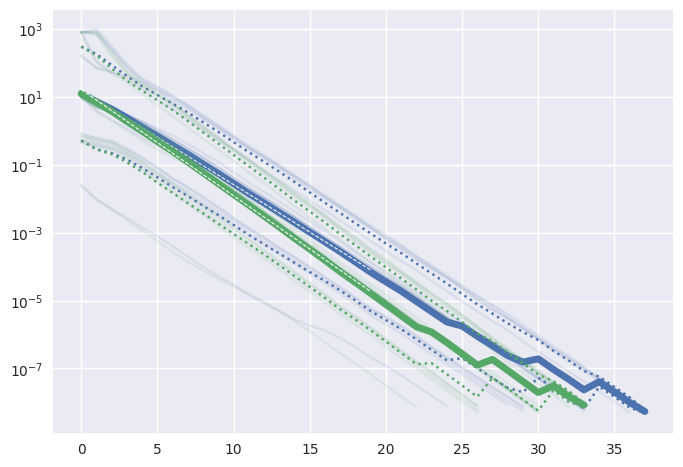

In [ ]:
DA_exp.plot_residuals_inner_loop(color='C0', label='baseline')
DA_spectral.plot_residuals_inner_loop(color='C1', label='spectralLMP')